In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
# from fastai.tabular import *
from fastai.text import *

In [3]:
PATH = Path()

In [ ]:
train = pd.read_csv(PATH/"train.csv")
test = pd.read_csv(PATH/"test.csv")

# Data Visualization

IMPORTANT: While the time series appears continuous, the data is from discrete batches of 50 seconds long 10 kHz samples (500,000 rows per batch). In other words, the data from 0.0001 - 50.0000 is a different batch than 50.0001 - 100.0000, and thus discontinuous between 50.0000 and 50.0001

In [4]:
train.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [ ]:
train.tail()

In [ ]:
len(train)

In [ ]:
# signal stats
print(f"mean: {train.signal.mean()}\nmin: {train.signal.min()}\nmax: {train.signal.max()}")

In [ ]:
# open channel stats
print(f"mean: {train.open_channels.mean()}\nmin: {train.open_channels.min()}\nmax: {train.open_channels.max()}")

In [6]:
res = 10000    # step

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(train.signal[0::res])

plt.vlines(range(0,len(train),500000),-5,14,'r')  # delineate batches (vertically from -5 to 12.5)
for j in range(10): plt.text(j*500000+200000,13,str(j+1),size=20)  # show batch numbers

plt.xlabel('Time (*1e4)', size=16)
plt.ylabel('Signal', size=16); 
plt.title(f'Signal - batches / {res}',size=20)
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(train.open_channels[0::res])

plt.vlines(range(0,len(train),500000),-1,14,'r')  # delineate batches (vertically from -5 to 12.5)
for j in range(10): plt.text(j*500000+200000,13,str(j+1),size=20)  # show batch numbers

plt.xlabel('Time (*1e4)', size=16)
plt.ylabel('Open Channels', size=16);
plt.title(f'Open Channels - batches / {res}',size=20)
plt.show()

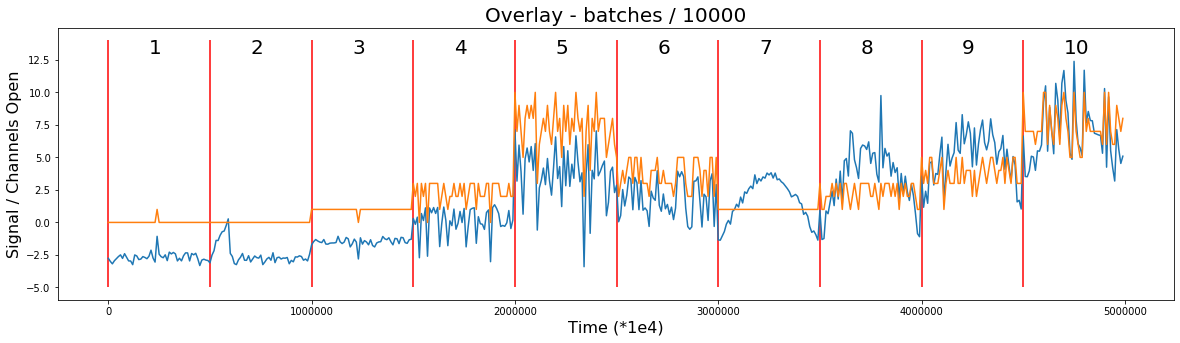

In [298]:
plt.figure(figsize=(20,5))
plt.plot(train.signal[::res])
plt.plot(train.open_channels[::res])

plt.vlines(range(0,len(train),500000),-5,14,'r')  # delineate batches (vertically from -5 to 12.5)
for j in range(10): plt.text(j*500000+200000,13,str(j+1),size=20)  # show batch numbers

plt.xlabel('Time (*1e4)', size=16)
plt.ylabel('Signal / Channels Open', size=16); 
plt.title(f'Overlay - batches / {res}',size=20)
plt.show()

## zoom in

In [8]:
def show_subsets(n=10, length=500, step=10):
    for k in range(n):
        start = np.random.randint(0, len(train)-length)
        end = start + length
        plt.figure(figsize=(20,5))
        plt.plot(train.signal[start:end:step])
        plt.plot(train.open_channels[start:end:step])
        plt.xlabel('Time (*1e4)', size=16)
        plt.ylabel('Signal / Channels Open', size=16); 
        plt.title(f'{start} - {end}  ({length}/{step})',size=20)
        plt.show()

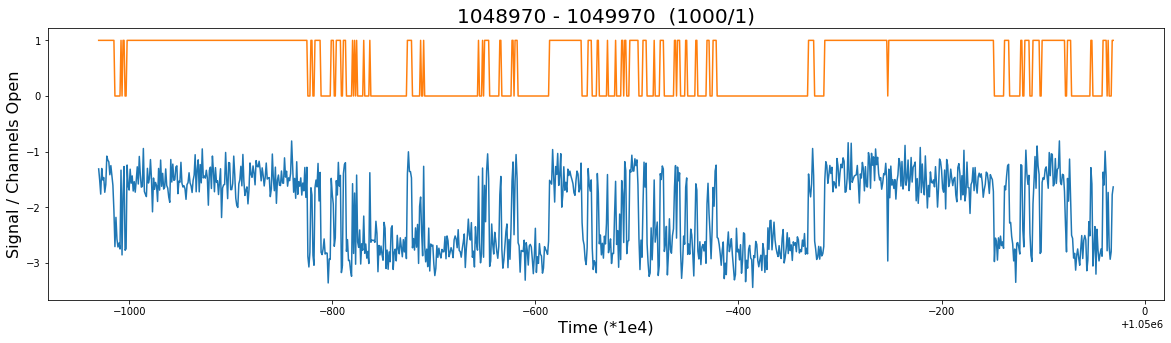

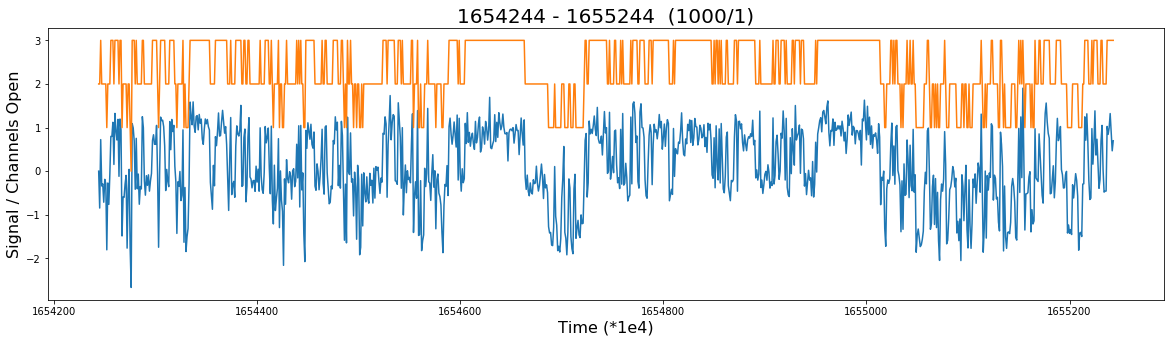

In [9]:
show_subsets(n=2, length=1000, step=1)

## Test

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(test.signal[0::res])

plt.vlines(range(0,len(test),500000),-5,14,'r')  # delineate batches (vertically from -5 to 12.5)
for j in range(4): plt.text(j*500000+200000,13,str(j+1),size=20)  # show batch numbers

plt.xlabel('Time (*1e4)', size=16)
plt.ylabel('Signal', size=16); 
plt.title(f'Signal - batches / {res}',size=20)
plt.show()

# DataBunch

In [10]:
class NormProcessor(PreProcessor):
    def __init__(self, ds:Collection=None):
        self.means = ds.items.mean()
        self.stds = ds.items.std()

    def process_one(self, item:Any): return self.norm(item)
    def process(self, ds:Collection): ds.items = self.norm(ds.items)
    
    def norm(self, x): return (x - self.means)/(self.stds + 1e-7)

In [213]:
class SeqBatchSampler(torch.utils.data.Sampler):
    "Return batches of indexes ~> [bs,bptt]"
    def __init__(self,data_source,bs=10,bptt=5000):
        self.length = len(data_source)
        assert self.length%bs==0
        self.bs,self.bptt = bs,bptt
        self.idxs = np.arange(self.length).reshape((bs,-1))

    def __len__(self): return self.length//self.bs
    
    def __iter__(self):
        self.cur_idx = 0
        return self
        
    def __next__(self):
        cur = self.cur_idx
        end = cur+self.bptt
        self.cur_idx = end
        res = self.idxs[:,cur:end]
        if res.shape[1] == 0: raise StopIteration
        return res

In [214]:
def custom_collate(data):
    x,y = [],[]
    for ll in data:
        x.append(ll.x.items)
        y.append(ll.y.items)
    return (torch.Tensor(x), torch.Tensor(y))

In [366]:
class SeqDataBunch(DataBunch):
    @classmethod      # cls => databunch Class
    def create(cls, train_ds, valid_ds, test_ds=None, path='.', bs:int=10, bptt:int=5000, **kwargs) -> DataBunch:
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        dataloaders = []
        for ds in datasets:
            samp = SeqBatchSampler(ds,bs=bs,bptt=bptt)
            dataloaders.append(DataLoader(ds, batch_sampler=samp))
        return cls(*dataloaders, path=path, collate_fn=custom_collate)
    
    def normalize(self, mean=0., std=1.)->None:
        self.add_tfm(partial(self.norm_x, mean=mean, std=std))
        return self
    
    @staticmethod
    def norm_x(batch:Tuple[Tensor,Tensor], mean:float, std:float)->Tuple[Tensor,Tensor]:
        x,y = batch
        x = (x-mean)/std
        return x,y

In [367]:
class SeqList(ItemList): 
    #_processor = [NormProcessor]
    _bunch = SeqDataBunch

    def analyze_pred(self, pred:Tensor):
        return torch.argmax(pred, dim=-1)

In [268]:
def valid_idxs(df,bs=10,percent=0.2):
    length = len(df)
    pct = length/bs*percent
    assert pct.is_integer()
    return np.arange(length).reshape(bs,-1)[:,-int(pct):].flatten()

In [292]:
bs=10
bptt=5000

In [272]:
v_idxs = valid_idxs(train, bs=bs)

In [377]:
data = (SeqList.from_df(train, PATH, cols=1)
        .split_by_idx(v_idxs)
        .label_from_df(cols=2)
        .databunch(bs=bs, bptt=bptt)
       )

In [ ]:
data = data.normalize(mean=1.5597, std=3.4347)

## Visualize (unnormalized) training batch

In [282]:
x,y = next(iter(data.train_dl))

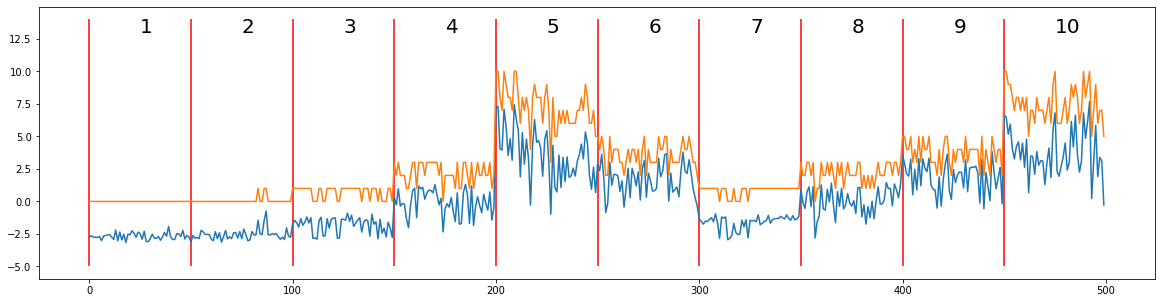

In [303]:
step = 100
seq = bptt//step

plt.figure(figsize=(20,5))
plt.plot(x.numpy().flatten()[::step])
plt.plot(y.numpy().flatten()[::step])

plt.vlines(range(0,bs*seq,seq),-5,14,'r')  # delineate batches (vertically from -5 to 12.5)
for j in range(bs): plt.text(j*seq+(seq/2),13,str(j+1),size=20)  # show batch numbers

plt.show()

## Visualize (normalized) training batch

In [378]:
data = data.normalize(mean=1.5597, std=3.4347)

In [379]:
x,y = next(iter(data.train_dl))

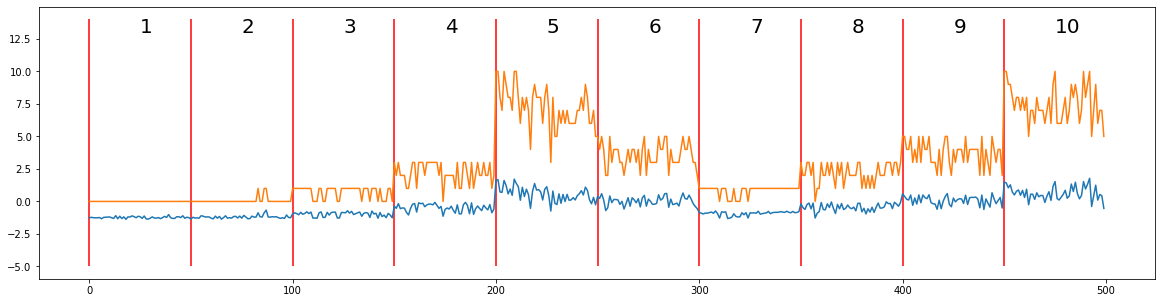

In [380]:
step = 100
seq = bptt//step

plt.figure(figsize=(20,5))
plt.plot(x.numpy().flatten()[::step])
plt.plot(y.numpy().flatten()[::step])

plt.vlines(range(0,bs*seq,seq),-5,14,'r')  # delineate batches (vertically from -5 to 12.5)
for j in range(bs): plt.text(j*seq+(seq/2),13,str(j+1),size=20)  # show batch numbers

plt.show()

# Basic NN

In [391]:
class mod_AWD_LSTM(Module):
    def __init__(self, in_sz:int, n_hid:int, n_layers:int, hidden_p:float=0.2,
                 input_p:float=0.6, weight_p:float=0.5, bidir:bool=False):
        self.bs,self.in_sz,self.n_hid,self.n_layers = 1,in_sz,n_hid,n_layers
        self.n_dir = 2 if bidir else 1

        self.rnns = [nn.LSTM(self.in_sz if l == 0 else self.n_hid, self.n_hid//self.n_dir, 1,
                             batch_first=True, bidirectional=bidir) for l in range(n_layers)]
        self.rnns = [WeightDropout(rnn, weight_p) for rnn in self.rnns]
        self.rnns = nn.ModuleList(self.rnns)
        self.input_dp = RNNDropout(input_p)
        self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(n_layers)])

    def forward(self, input:Tensor)->Tuple[Tensor,Tensor]:
        bs,sl = input.size()
        if bs!=self.bs:
            self.bs=bs
            self.reset()
        raw_output = self.input_dp(input)
        new_hidden,raw_outputs,outputs = [],[],[]
        for l, (rnn,hid_dp) in enumerate(zip(self.rnns, self.hidden_dps)):
            raw_output, new_h = rnn(raw_output, self.hidden[l])
            new_hidden.append(new_h)
            raw_outputs.append(raw_output)
            if l != self.n_layers-1: raw_output = hid_dp(raw_output)
            outputs.append(raw_output)
        self.hidden = to_detach(new_hidden, cpu=False)
        return raw_outputs, outputs

    def _one_hidden(self, l:int)->Tensor:
        "Return one hidden state."
        nh = self.n_hid // self.n_dir
        return one_param(self).new(self.n_dir, self.bs, nh).zero_()

    def reset(self):
        "Reset the hidden states."
        [r.reset() for r in self.rnns if hasattr(r, 'reset')]
        self.hidden = [(self._one_hidden(l), self._one_hidden(l)) for l in range(self.n_layers)]

In [ ]:
class SeqModel(Module):
    def __init__(self, ):
        self.conv1 = nn.Conv1d(1,32,3,padding=1)
        self.awd_lstm = mod_AWD_LSTM(32,64,3)
        
    def forward(self, input:Tensor):
        

In [384]:
x.unsqueeze(1).shape

torch.Size([10, 1, 5000])

In [388]:
conv = nn.Conv1d(1,16,3,padding=1)

In [389]:
res = conv(x.unsqueeze(1))

In [390]:
res.shape

torch.Size([10, 16, 5000])

# Tabular Model

In [381]:
tab_data = TabularDataBunch.from_df(PATH, train[['signal','open_channels']], 'open_channels',
                                    valid_idx=range(4000000, 5000000))#, procs=[Normalize])

NameError: name 'TabularDataBunch' is not defined

In [ ]:
f1 = FBeta(average='macro', beta=1.0)

In [ ]:
learn = tabular_learner(tab_data, layers=[32,64], metrics=[accuracy, f1])

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-2)

In [ ]:
learn.save('tab_model')

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
itr = iter(data.valid_dl)

In [ ]:
x,y = next(itr)

In [ ]:
y

In [ ]:
m = learn.model

In [ ]:
m.eval(); None

In [ ]:
with torch.no_grad():
    res = m(*x)
    preds = res.argmax(dim=-1)

In [ ]:
preds

In [ ]:
y

In [ ]:
f1_score(y, preds, average='macro')

# F1 evaluation

*positive class*: minority class(es)  
*negative class*: majority class

- Precision: number of true positive class predictions.  (minority class accuracy)
- Recall: number of positive class predictions made out of all positive examples in the dataset. (minority class coverage)
- F-Measure provides a single score that balances both the concerns of precision and recall in one number.

*precision* - TruePositives / (TruePositives + FalsePositives)  
*recall* - TruePositives / (TruePositives + FalseNegatives)

| *Binary*        | Positive Prediction | Negative Prediction |
| :-------------: | ------------------- | ------------------- |
|**Positive Class** | True Positive (TP) | False Negative (FN) |
|**Negative Class** | False Positive (FP) | True Negative (TN) |

In [ ]:
TP = (preds * y).sum(); TP

In [ ]:
prec = TP / preds.sum(); prec

In [ ]:
rec = TP / y.sum(); rec

In [ ]:
f1 = (prec*rec)/(prec+rec+1e-9)*2; f1

In [ ]:
TP = (y_pred*y_true).sum()
prec = TP/(y_pred.sum(dim=1)+eps)
rec = TP/(y_true.sum(dim=1)+eps)
res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)

In [ ]:
def evaluate(model,x,y):
    model.eval()
    with torch.no_grad():
        res = model(x)
        preds = res.argmax(dim=-1)
        f1
learn.model()